In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [146]:
nlp = spacy.load("en_core_web_trf")

# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES

In [ ]:
def load_and_prepare_data():
    """
    Chargement et préparation des données des rumeurs
    Remplacez cette fonction par votre propre logique de chargement
    """
    
    df = pd.read_csv(r'\Transfers_Rumors\data\rumors_fabrizio_romano_final.csv')
    
    # Ajout de features temporelles

    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour  # 0 if no time part exists
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    return df

# 2. EXTRACTION DE FEATURES

In [ ]:
class FeatureExtractor:
    """
    Extracteur de features avancées avec spaCy
    """
    
    def __init__(self):
        self.nlp = nlp
        self.confidence_words = {
    'high': ['here we go', 'confirmed', 'official', 'done deal', 'completed', 
             'signed', 'agreement sealed', 'announcement soon'],
    'medium': ['close', 'advanced', 'almost done', 'final stages', 'details being sorted', 
               'expected soon', 'positive talks'],
    'low': ['interest', 'monitoring', 'approach', 'talks ongoing', 
            'considering', 'waiting', 'bid sent', 'exploring']
}
        
        self.transfer_entities = ['PERSON', 'ORG']  # Personnes, organisations
        
    def extract_text_features(self, texts):
        """
        Extraction de features textuelles avancées avec spaCy
        """
        print("🔍 Extraction des features textuelles avec spaCy...")
        
        features = []
        all_embeddings = []
        
        for text in texts:
            doc = self.nlp(text)
            text_features = {}
            
            # 1. FEATURES D'EMBEDDINGS (vecteurs de mots)
            # Moyenne des embeddings des mots significatifs
            word_vectors = [token.vector for token in doc 
                          if not token.is_stop and not token.is_punct and token.has_vector]
            
            if word_vectors:
                embedding_mean = np.mean(word_vectors, axis=0)
                all_embeddings.append(embedding_mean)
            else:
                all_embeddings.append(np.zeros(self.nlp.vocab.vectors_length))
            
            # 2. FEATURES DE CONFIANCE (mots indicateurs de certitude)
            text_lower = text.lower()
            text_features['confidence_high'] = sum(1 for word in self.confidence_words['high'] 
                                                 if word in text_lower)
            text_features['confidence_medium'] = sum(1 for word in self.confidence_words['medium'] 
                                                   if word in text_lower)
            text_features['confidence_low'] = sum(1 for word in self.confidence_words['low'] 
                                                if word in text_lower)
            
            # 3. FEATURES LINGUISTIQUES
            text_features['num_tokens'] = len(doc)
            text_features['num_sentences'] = len(list(doc.sents))
            text_features['num_entities'] = len(doc.ents)
            text_features['num_transfer_entities'] = len([ent for ent in doc.ents 
                                                        if ent.label_ in self.transfer_entities])
            
            # 4. FEATURES SYNTAXIQUES
            text_features['num_verbs'] = len([token for token in doc if token.pos_ == 'VERB'])
            text_features['num_nouns'] = len([token for token in doc if token.pos_ == 'NOUN'])
            text_features['num_adjectives'] = len([token for token in doc if token.pos_ == 'ADJ'])
            
            # 5. FEATURES SÉMANTIQUES
            # Présence de mots-clés du transfert
            transfer_keywords = ['transfer', 'move', 'sign', 'deal', 'contract', 
                          'agreement', 'negotiation', 'offer', 'bid', 
                          'loan', 'medical', 'buy option', 'personal terms']
            text_features['transfer_keywords'] = sum(1 for keyword in transfer_keywords 
                                                   if keyword in text_lower)
            
            # 6. POLARITÉ DES ENTITÉS NOMMÉES
            text_features['has_player_name'] = int(any(ent.label_ == 'PERSON' for ent in doc.ents))
            text_features['has_club_name'] = int(any(ent.label_ in ['ORG', 'GPE'] for ent in doc.ents))
            
            # 7. FEATURES DE STRUCTURE
            text_features['avg_word_length'] = np.mean([len(token.text) for token in doc 
                                                      if not token.is_space])
            text_features['punctuation_ratio'] = len([token for token in doc if token.is_punct]) / len(doc)
            
            features.append(text_features)
        
        # Conversion en DataFrame
        features_df = pd.DataFrame(features)
        
        # Ajout des embeddings comme features
        embeddings_df = pd.DataFrame(all_embeddings, 
                                   columns=[f'embedding_{i}' for i in range(len(all_embeddings[0]))])
        
        # Combinaison des features
        combined_features = pd.concat([features_df, embeddings_df], axis=1)
        
        print(f"✅ {len(combined_features.columns)} features textuelles extraites")
        
        return combined_features
    
    def analyze_text_patterns(self, df, model=None, feature_columns=None):
        """
        Analyse des patterns textuels selon la réalisation des rumeurs.
        Si 'realized' n'existe pas dans df, utilise un modèle pour prédire cette colonne.
        """
        print("\n📊 Analyse des patterns textuels")
        print("-" * 40)

        if 'realized' not in df.columns:
            if model is None or feature_columns is None:
                raise ValueError("Le modèle et les colonnes de features doivent être fournis pour la prédiction.")
            df['realized'] = model.predict(df[feature_columns])

        realized_texts = df[df['realized'] == 1]['texte'].tolist()
        not_realized_texts = df[df['realized'] == 0]['texte'].tolist()

        # Analyse des mots de confiance
        confidence_analysis = {}
        for level in ['high', 'medium', 'low']:
            realized_count = sum(sum(1 for word in self.confidence_words[level] if word in text.lower())
                                for text in realized_texts)
            not_realized_count = sum(sum(1 for word in self.confidence_words[level] if word in text.lower())
                                    for text in not_realized_texts)

            confidence_analysis[f'confidence_{level}'] = {
                'realized': realized_count / max(1, len(realized_texts)),
                'not_realized': not_realized_count / max(1, len(not_realized_texts))
            }

        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, level in enumerate(['high', 'medium', 'low']):
            data = confidence_analysis[f'confidence_{level}']
            axes[i].bar(['Réalisées', 'Non réalisées'], 
                        [data['realized'], data['not_realized']],
                        color=['green', 'red'], alpha=0.7)
            axes[i].set_title(f'Mots de confiance {level.upper()}')
            axes[i].set_ylabel('Moyenne par rumeur')

        plt.tight_layout()
        plt.show()

        return confidence_analysis


# 3. PRÉPARATION DES FEATURES

In [150]:
class RumorDetectionModel:
    """
    Modèle de détection des rumeurs 
    """
    
    def __init__(self, include_sentiment=True):
        self.include_sentiment = include_sentiment
        self.model = None
        self.scaler = StandardScaler()
        self.feature_extractor = FeatureExtractor()
        self.feature_names = None
        
    def prepare_data(self, df):
        """Préparation des données"""
        print(f"\n🔧 Préparation des features (sentiment: {'inclus' if self.include_sentiment else 'exclu'})")
        
        # Extraction des features textuelles avec spaCy
        text_features = self.feature_extractor.extract_text_features(df['texte'].tolist())
        
        # Features numériques de base
        numeric_features = ['performance', 'market_value', 'count_rumor', 
                           'day_of_week', 'hour', 'days_since_start']
        
        if self.include_sentiment:
            numeric_features.append('sentiment')
        
        # Combinaison des features
        X_numeric = df[numeric_features]
        X_combined = pd.concat([X_numeric.reset_index(drop=True), text_features], axis=1)
        
        self.feature_names = X_combined.columns.tolist()
        
        # Normalisation
        X_scaled = self.scaler.fit_transform(X_combined)
        y = df['realized'].values
        
        return X_scaled, y
    
    def train(self, df, test_size=0.2, random_state=42):
        """Entraînement du modèle"""
        print(f"\n🚀 Entraînement du modèle {'avec' if self.include_sentiment else 'sans'} sentiment")

        # Analyse des patterns textuels
        self.feature_extractor.analyze_text_patterns(df)

        # Préparation des données
        X, y = self.prepare_data(df)

        # Division train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Conversion en DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Paramètres du modèle
        params = {
            'objective': 'binary:logistic',
            'max_depth': 8,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'eval_metric': 'logloss',
            'seed': random_state
        }

        # Entraînement avec early stopping
        self.model = xgb.train(
            params,
            dtrain,
            num_boost_round=300,
            evals=[(dtest, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Prédictions
        y_prob = self.model.predict(dtest)
        y_pred = (y_prob > 0.5).astype(int)

        # Évaluation
        self.evaluate_model(y_test, y_pred, y_prob)

        return X_train, X_test, y_train, y_test, y_pred, y_prob

    
    def evaluate_model(self, y_true, y_pred, y_prob):
        """Évaluation du modèle"""
        print(f"\n📊 Évaluation du modèle {'avec' if self.include_sentiment else 'sans'} sentiment")
        print("-" * 60)
        
        # Métriques
        accuracy = accuracy_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        
        # Rapport de classification
        print("\nRapport de classification:")
        print(classification_report(y_true, y_pred))
        
        # Matrice de confusion
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matrice de Confusion {"Avec" if self.include_sentiment else "Sans"} Sentiment')
        plt.ylabel('Vraie Classe')
        plt.xlabel('Classe Prédite')
        plt.show()
        
        # Courbe ROC
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('Taux de Faux Positifs')
        plt.ylabel('Taux de Vrais Positifs')
        plt.title(f'Courbe ROC {"Avec" if self.include_sentiment else "Sans"} Sentiment')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return accuracy, auc_score
    
    def plot_feature_importance(self, top_n=20):
        """Affichage de l'importance des features"""
        if self.model is None:
            print("Modèle non entraîné!")
            return
        
        # Importance des features
        importance = self.model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Graphique
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(top_n)
        sns.barplot(data=top_features, y='feature', x='importance')
        plt.title(f'Top {top_n} - {"Avec" if self.include_sentiment else "Sans"} Sentiment')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        # Analyse par catégorie de features
        self.analyze_feature_categories(feature_importance)
        
        return feature_importance
    
    def analyze_feature_categories(self, feature_importance):
        """Analyse de l'importance par catégorie de features"""
        print("\n📈 Analyse par catégorie de features:")
        print("-" * 40)
        
        categories = {
            'Confiance': ['confidence_high', 'confidence_medium', 'confidence_low'],
            'Linguistiques': ['num_tokens', 'num_sentences', 'num_entities', 'num_verbs', 'num_nouns'],
            'Transfert': ['transfer_keywords', 'has_player_name', 'has_club_name'],
            'Embeddings': [f for f in feature_importance['feature'] if f.startswith('embedding_')],
            'Numériques': ['performance', 'market_value', 'count_rumor', 'sentiment'],
            'Temporelles': ['day_of_week', 'hour', 'days_since_start']
        }
        
        category_importance = {}
        for category, features in categories.items():
            category_features = feature_importance[feature_importance['feature'].isin(features)]
            if not category_features.empty:
                category_importance[category] = category_features['importance'].sum()
        
        # Graphique des catégories
        plt.figure(figsize=(10, 6))
        categories_sorted = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
        cats, values = zip(*categories_sorted)
        
        plt.bar(cats, values, color=plt.cm.Set3(np.linspace(0, 1, len(cats))))
        plt.title('Importance par Catégorie de Features')
        plt.ylabel('Importance Totale')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        for category, importance in categories_sorted:
            print(f"{category}: {importance:.4f}")

In [ ]:
df = load_and_prepare_data(sentiment=True)

# 4. EXPÉRIMENTATION DES DEUX APPROCHES


🎯 APPROCHE 1: AVEC SCORE DE SENTIMENT

🚀 Entraînement du modèle avec sentiment

📊 Analyse des patterns textuels
----------------------------------------


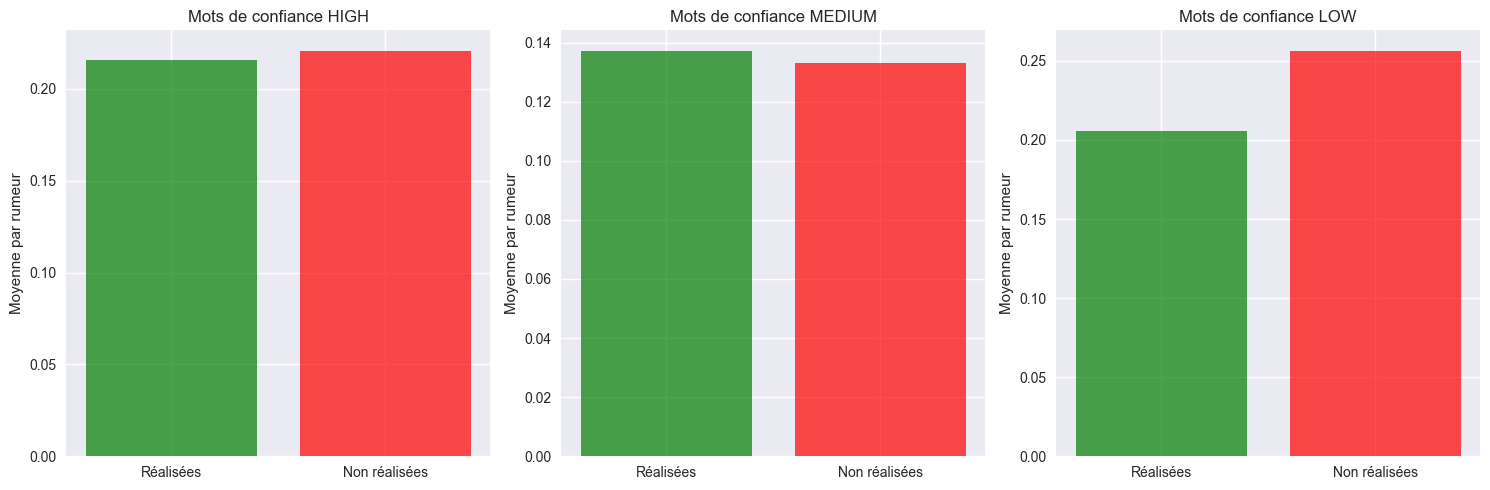


🔧 Préparation des features (sentiment: inclus)
🔍 Extraction des features textuelles avec spaCy...
✅ 15 features textuelles extraites

📊 Évaluation du modèle avec sentiment
------------------------------------------------------------
Accuracy: 0.4553
AUC Score: 0.4577

Rapport de classification:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49        62
           1       0.44      0.39      0.42        61

    accuracy                           0.46       123
   macro avg       0.45      0.45      0.45       123
weighted avg       0.45      0.46      0.45       123



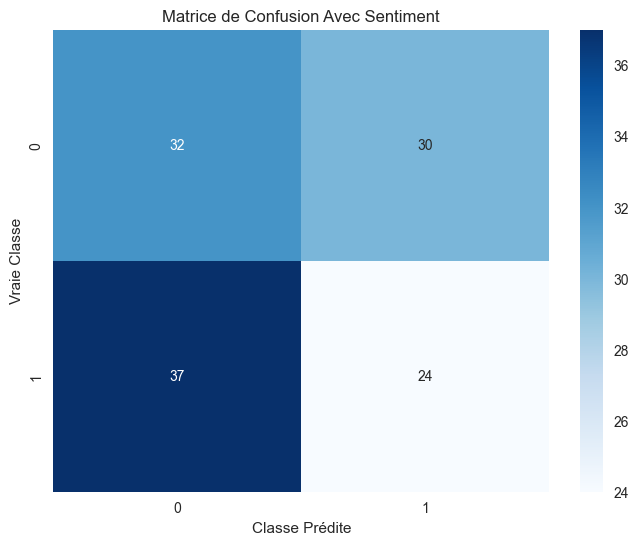

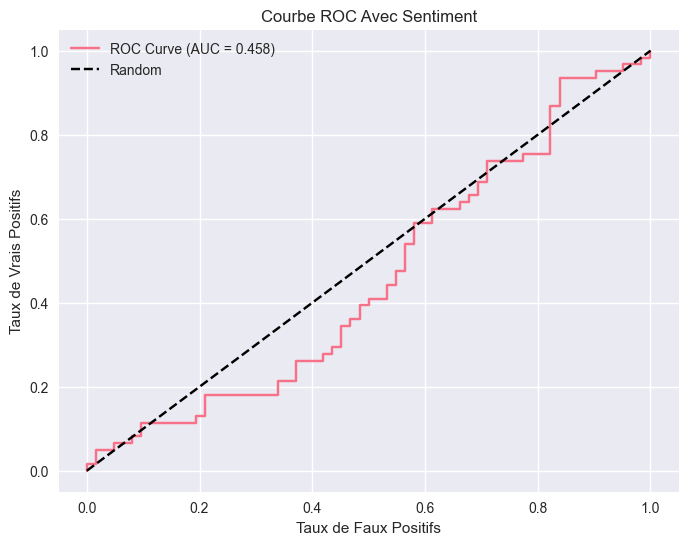


📊 Évaluation du modèle avec sentiment
------------------------------------------------------------
Accuracy: 0.4553
AUC Score: 0.4577

Rapport de classification:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49        62
           1       0.44      0.39      0.42        61

    accuracy                           0.46       123
   macro avg       0.45      0.45      0.45       123
weighted avg       0.45      0.46      0.45       123



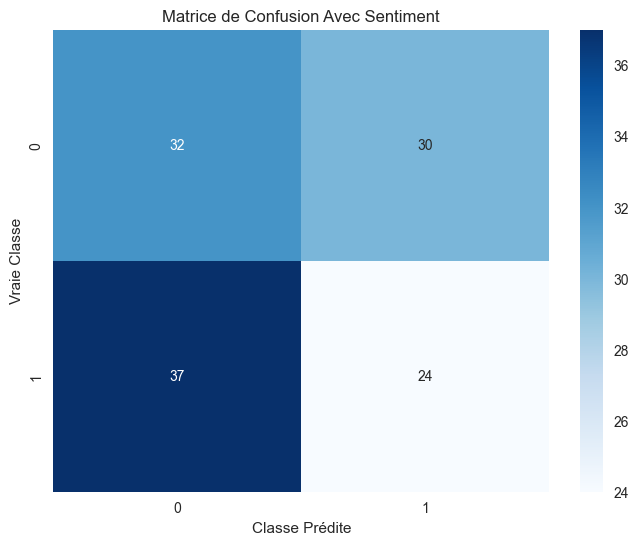

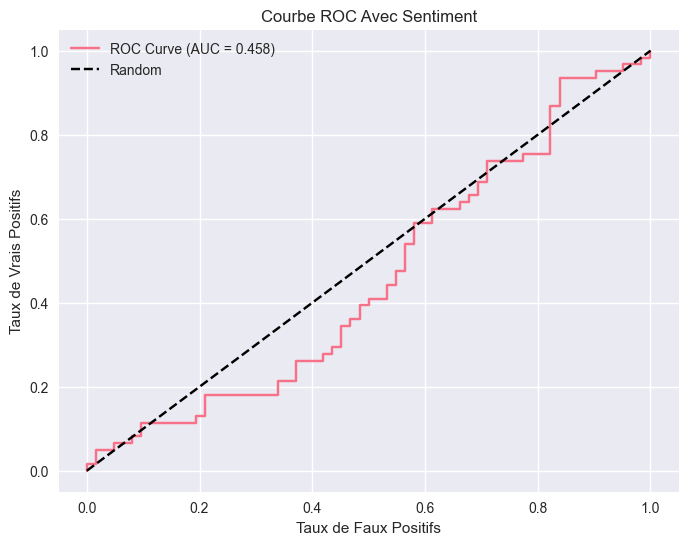

In [152]:
# Approche 1: Avec sentiment
print("\n🎯 APPROCHE 1: AVEC SCORE DE SENTIMENT")
model_with_sentiment = RumorDetectionModel(include_sentiment=True)
results_with = model_with_sentiment.train(df)
acc_with, auc_with = model_with_sentiment.evaluate_model(
    results_with[3], results_with[4], results_with[5]
)


🎯 APPROCHE 2: SANS SCORE DE SENTIMENT (ENRICHIE)

🚀 Entraînement du modèle sans sentiment

📊 Analyse des patterns textuels
----------------------------------------


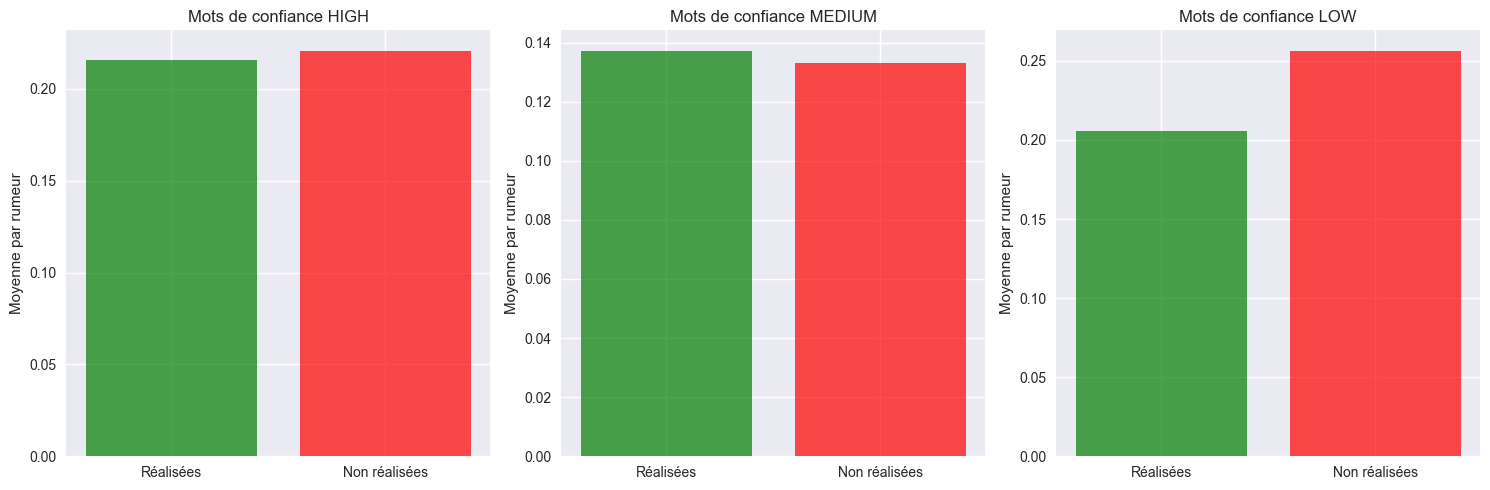


🔧 Préparation des features (sentiment: exclu)
🔍 Extraction des features textuelles avec spaCy...
✅ 15 features textuelles extraites

📊 Évaluation du modèle sans sentiment
------------------------------------------------------------
Accuracy: 0.5447
AUC Score: 0.5108

Rapport de classification:
              precision    recall  f1-score   support

           0       0.54      0.61      0.58        62
           1       0.55      0.48      0.51        61

    accuracy                           0.54       123
   macro avg       0.55      0.54      0.54       123
weighted avg       0.54      0.54      0.54       123



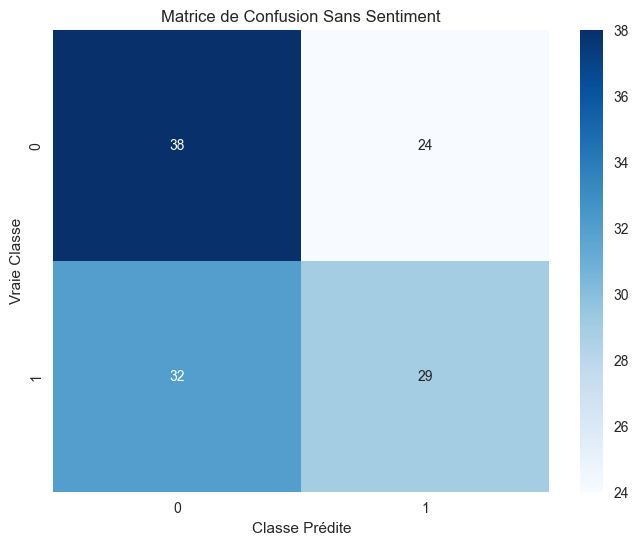

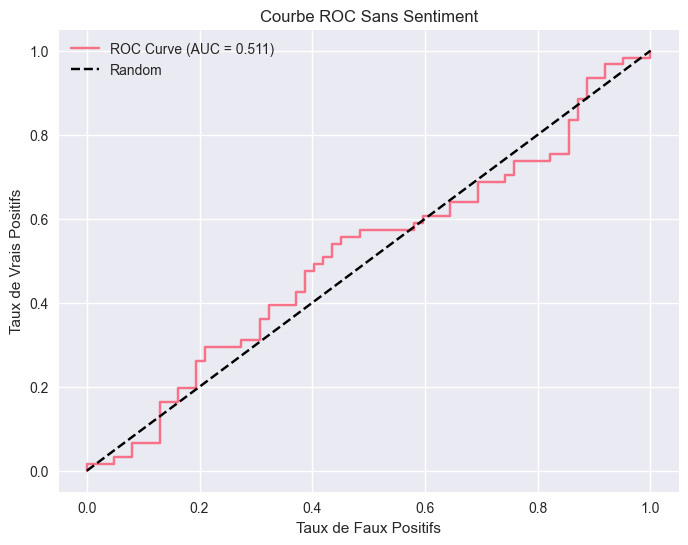


📊 Évaluation du modèle sans sentiment
------------------------------------------------------------
Accuracy: 0.5447
AUC Score: 0.5108

Rapport de classification:
              precision    recall  f1-score   support

           0       0.54      0.61      0.58        62
           1       0.55      0.48      0.51        61

    accuracy                           0.54       123
   macro avg       0.55      0.54      0.54       123
weighted avg       0.54      0.54      0.54       123



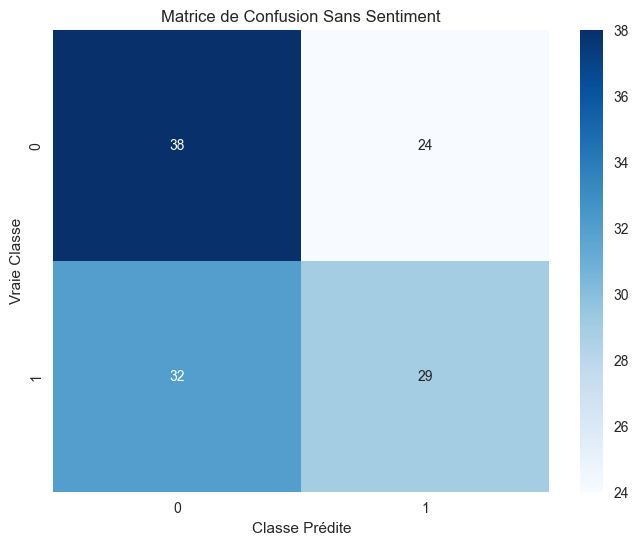

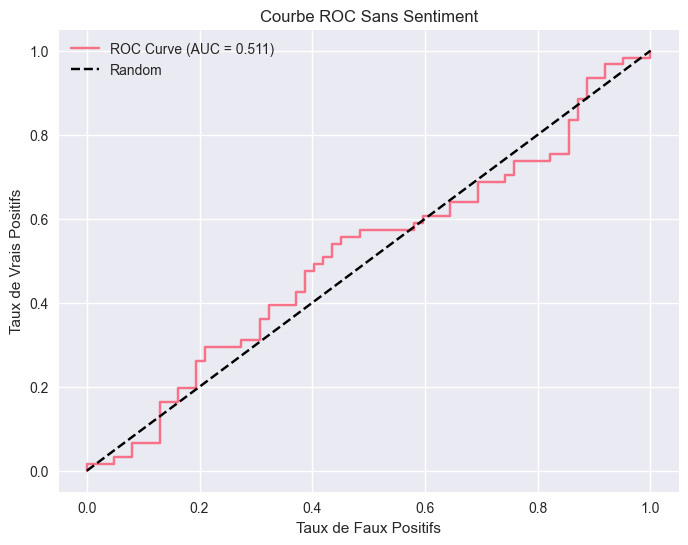

In [153]:
print("\n🎯 APPROCHE 2: SANS SCORE DE SENTIMENT (ENRICHIE)")
model_without_sentiment = RumorDetectionModel(include_sentiment=False)
results_without = model_without_sentiment.train(df)
acc_without, auc_without = model_without_sentiment.evaluate_model(
    results_without[3], results_without[4], results_without[5]
)

# 6. COMPARAISON DES APPROCHES


📊 COMPARAISON DES DEUX APPROCHES
         Approche  Accuracy  AUC Score
0  Avec Sentiment  0.455285   0.457694
1  Sans Sentiment  0.544715   0.510841


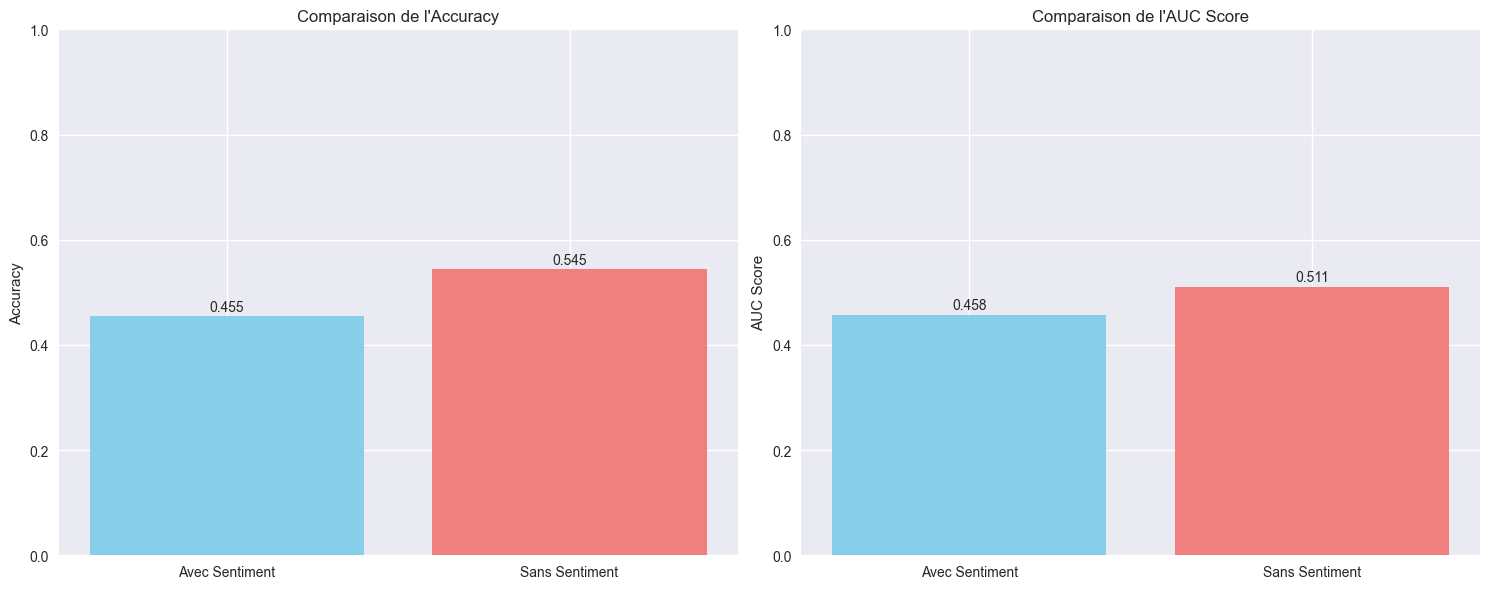

In [154]:
print("\n" + "="*60)
print("📊 COMPARAISON DES DEUX APPROCHES")
print("="*60)

comparison_df = pd.DataFrame({
    'Approche': ['Avec Sentiment', 'Sans Sentiment'],
    'Accuracy': [acc_with, acc_without],
    'AUC Score': [auc_with, auc_without]
})

print(comparison_df)

# Graphique de comparaison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
axes[0].bar(comparison_df['Approche'], comparison_df['Accuracy'], 
           color=['skyblue', 'lightcoral'])
axes[0].set_title('Comparaison de l\'Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# AUC Score
axes[1].bar(comparison_df['Approche'], comparison_df['AUC Score'], 
           color=['skyblue', 'lightcoral'])
axes[1].set_title('Comparaison de l\'AUC Score')
axes[1].set_ylabel('AUC Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(comparison_df['AUC Score']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()